In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as at
import seaborn as sns
import scipy.stats as st 
from scipy.stats import t
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc

Last updated: Fri Feb 02 2024

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.12.0

pymc: 5.10.3

scipy     : 1.12.0
matplotlib: 3.8.2
pymc      : 5.10.3
pytensor  : 2.18.6
arviz     : 0.17.0
pandas    : 2.2.0
seaborn   : 0.13.2
numpy     : 1.26.3

Watermark: 2.4.3



In [3]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [4]:
df = pd.read_excel(r"C:\Users\manhi\Documents\PPR_Senegal\python_scripts\envelopes_models\envelopes_data_minutes\under_1m\enveloppe5_0.2_pivot.xlsx")
df1 = pd.read_excel(r"C:\Users\manhi\Documents\PPR_Senegal\python_scripts\envelopes_models\envelopes_data_minutes\under_1m\enveloppe5_0.2.xlsx")
y = df1["infected"].to_numpy()

In [5]:
df.head()

,experiment,contact_duration,cap_ID,infected,distance,time
0,1,1h,100,0,0.974849,1
1,1,1h,100,0,0.632444,1
2,1,1h,100,0,0.768865,1
3,1,1h,100,0,0.924647,1
4,1,1h,100,0,0.602395,1


In [8]:
# Pre-calculate unique combinations of experiment and contact_duration
unique_combinations = df[['experiment', 'contact_duration']].drop_duplicates()

# Convert to a list of tuples for iteration
unique_combinations = [tuple(x) for x in unique_combinations.to_numpy()]

In [9]:
%%time
with pm.Model() as model:
    # Priors
    p0 = pm.Beta('p0', alpha=1, beta=1)
    lambda_ = pm.LogNormal('lambda', mu = -1, sigma=0.1)

    # Loop through data
    for e, c in unique_combinations:
        df_temp = df[(df['experiment'] == e) & (df['contact_duration'] == c)]
        ids = df_temp['cap_ID'].unique()
            
        # Iterate over unique cap_IDs
        # Group by cap_ID within this subset
        for _, group in df_temp.groupby('cap_ID'):
            distances = group['distance'].values
            times = group['time'].values
            
            # Vectorized calculation of p_temp
            p_temp = (1 - (p0 * pm.math.exp(-lambda_ * distances))) ** times
                
            # Product of probabilities for the cap_ID
            p_i = pm.math.prod(p_temp)
                
            # Final calculation for the cap_ID
            p = 1 - p_i
                
    # Likelihood
    # Use Bernoulli directly without the need for an additional list p
    y_true = pm.Bernoulli('y_obs', p = p, observed=y)

    inits = {'p0': 0.001, 'lambda': 0.1} 

    # Inference
    trace = pm.sample(10000, progressbar=True, tune=1000, chains=10, cores=4, target_accept=0.95, random_seed=42, initvals=inits)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [p0, lambda]


Sampling 10 chains for 1_000 tune and 10_000 draw iterations (10_000 + 100_000 draws total) took 91 seconds.


CPU times: total: 1min 41s
Wall time: 2min 52s


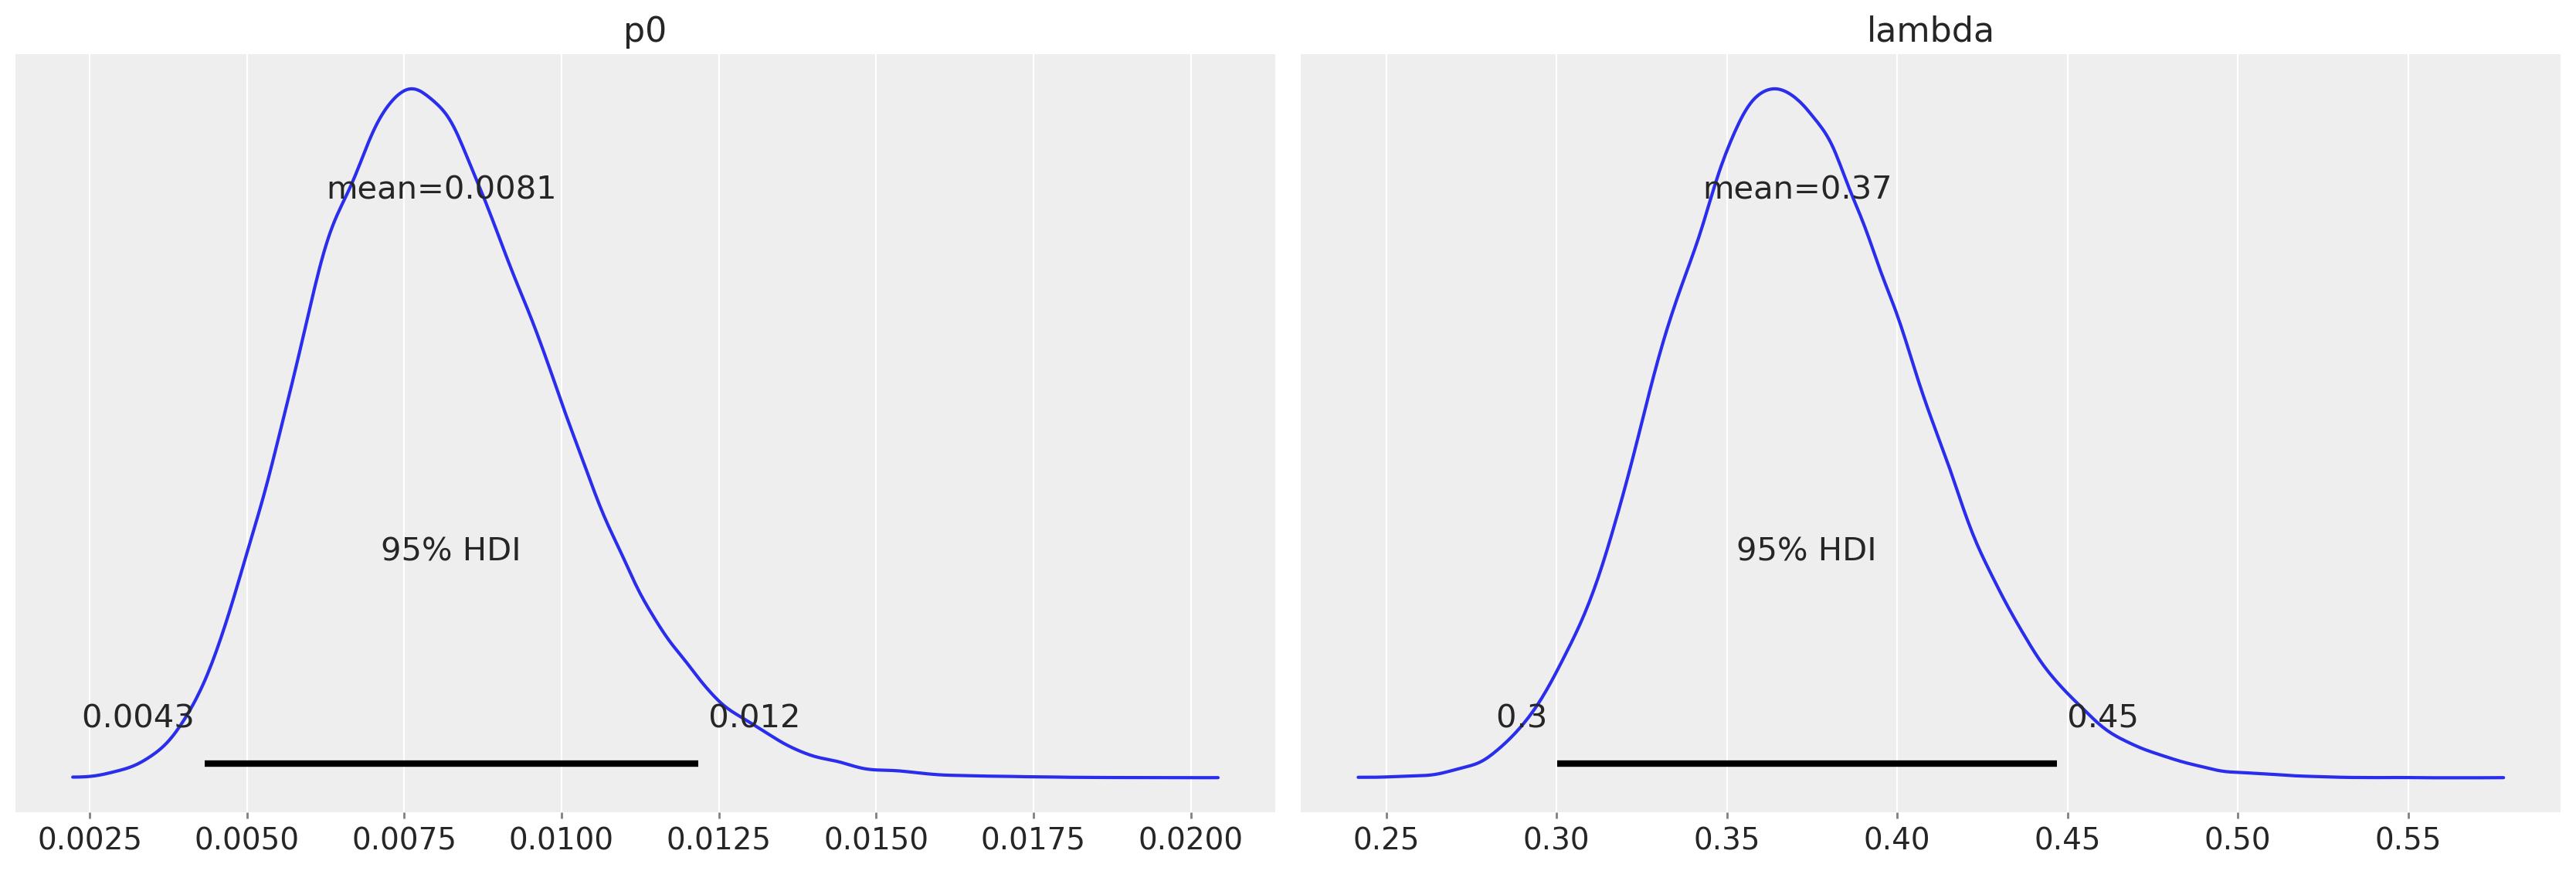

In [10]:
az.plot_posterior(trace, var_names=["p0", "lambda"], hdi_prob=.95);

In [11]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [12]:
az.summary(trace, round_to=4, hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p0,0.0081,0.0020,0.0043,0.0122,0.0000,0.0000,60723.1258,55168.3191,1.0001
lambda,0.3707,0.0375,0.3002,0.4468,0.0001,0.0001,65749.4054,59674.2461,1.0000


In [13]:
p0_sample = trace.posterior["p0"].stack(sample=("chain", "draw")).values
p0_sample = np.random.choice(p0_sample, size=1000)

In [14]:
lambda_sample = trace.posterior["lambda"].stack(sample=("chain", "draw")).values
lambda_sample = np.random.choice(lambda_sample, size=1000)

In [15]:
# Initialize the list for predictions
pred = []

# Iterate over samples
for j in range(len(lambda_sample)):
    a = lambda_sample[j]
    b = p0_sample[j]
    pred_parametre = []
    
    # Iterate over unique combinations of experiment and contact_duration
    for e, c in unique_combinations:
        df_temp = df[(df['experiment'] == e) & (df['contact_duration'] == c)]
        ids = df_temp['cap_ID'].unique()
        
        # Iterate over unique cap_IDs
        for id in ids:
            datai = df_temp[df_temp['cap_ID'] == id]
            distances = datai['distance'].values
            times = datai['time'].values
            
            # Vectorized calculation of p_temp
            p_temp = (1 - (b * np.exp(-a * distances))) ** times
            
            # Product of probabilities for the cap_ID
            p_i = np.prod(p_temp)
            
            # Append the final calculation for the cap_ID
            pred_parametre.append(1 - p_i)
    
    # Append predictions for this sample
    pred.append(pred_parametre)

In [16]:
# Créer le DataFrame
simulations = pd.DataFrame({f'y_pred{i+1}': sublist for i, sublist in enumerate(pred)})

simulations.insert(0, 'y_true', y)

In [17]:
y_true = simulations['y_true']

In [18]:
def plot_roc_curve(true_y, y_prob):

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    auc = roc_auc_score(true_y, y_prob)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:0.4f})')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve: enveloppes 1m , seuil = 0.2')
    plt.legend(loc="lower right")

In [20]:
aucs = []

# Boucle sur chaque colonne d'estimations
for col in simulations.columns[1:] : # Commencer à partir de la deuxième colonne car la première est y_true
    y_pred = simulations[col]
    auc = roc_auc_score(y_true, y_pred)
    aucs.append(auc)


In [21]:
# Trouver l'indice du maximum dans la liste d'AUC
indice_max_auc = np.argmax(aucs)

# Récupérer la colonne d'estimation avec le maximum d'AUC
col_max_auc = simulations.columns[indice_max_auc + 1]  # +1 pour compenser la première colonne (y_true)

# Afficher la colonne d'estimation avec le maximum d'AUC
print(f"La colonne avec le maximum d'AUC est : {col_max_auc}")

La colonne avec le maximum d'AUC est : y_pred66


In [22]:
mean_auc = np.mean(aucs)
median_auc = np.median(aucs)

print("mean auc:", mean_auc)
print("median auc:", median_auc)

q1 = np.quantile(aucs, 0.25)
q3 = np.quantile(aucs, 0.75)

if q3 == q1: 
   print("Not enough data")
else:
   iqr = q3 - q1  
   lower = q1 - 1.5 * iqr
   upper = q3 + 1.5 * iqr 
   conf_interval = (lower, upper)

   print(conf_interval)

mean auc: 0.5439939393939394
median auc: 0.543939393939394
Not enough data


In [24]:
y_pred = simulations['y_pred66']

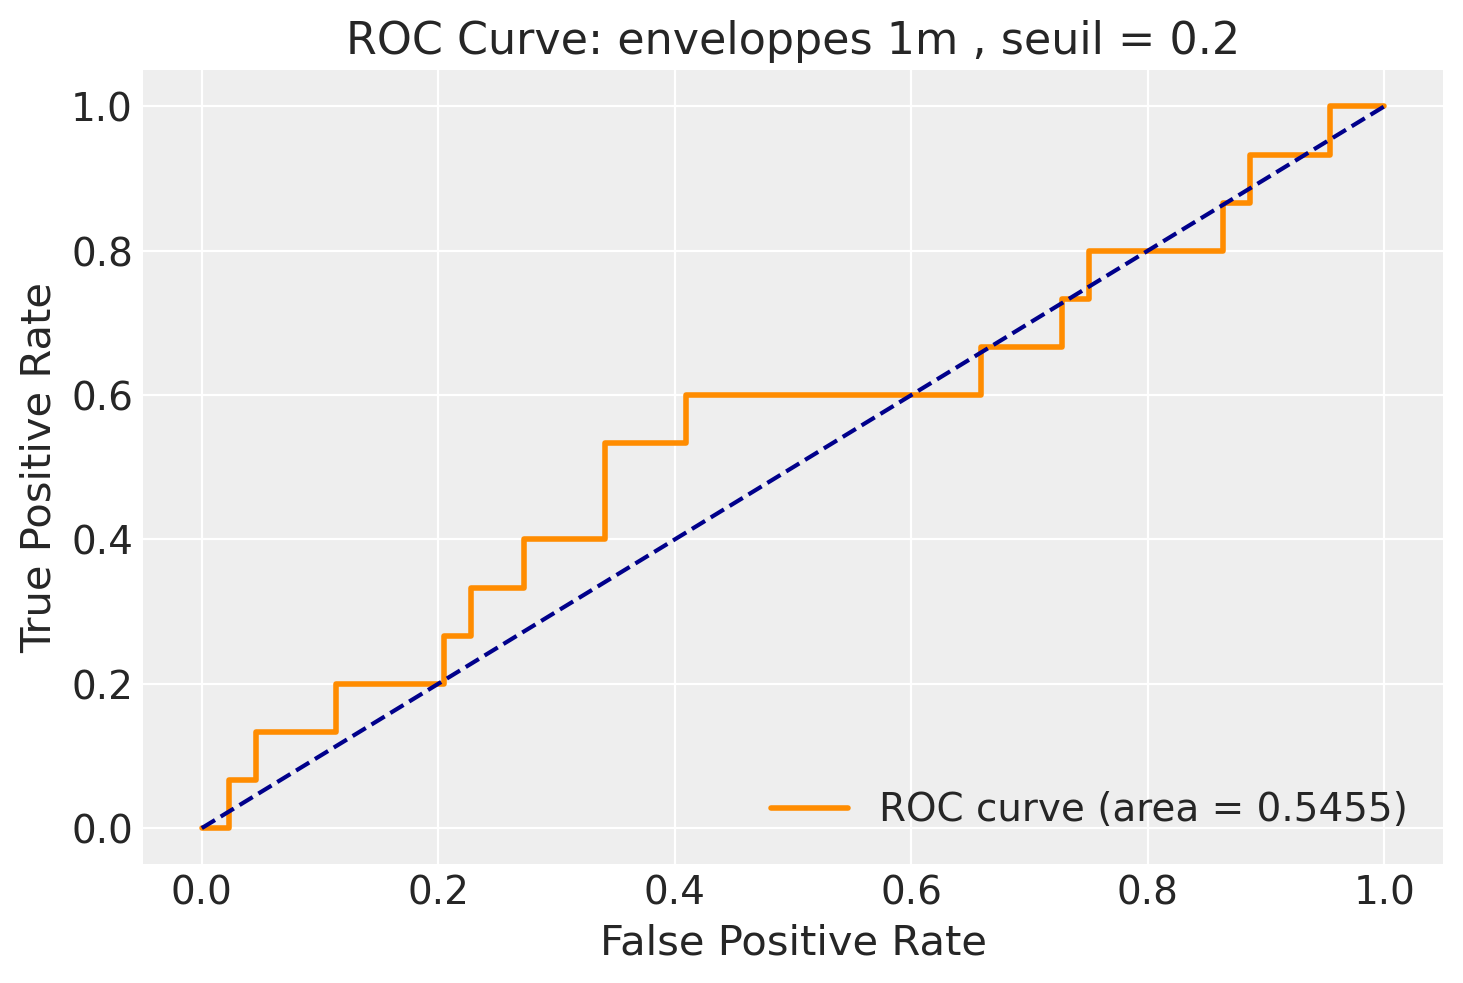

In [25]:
plot_roc_curve(y_true, y_pred)

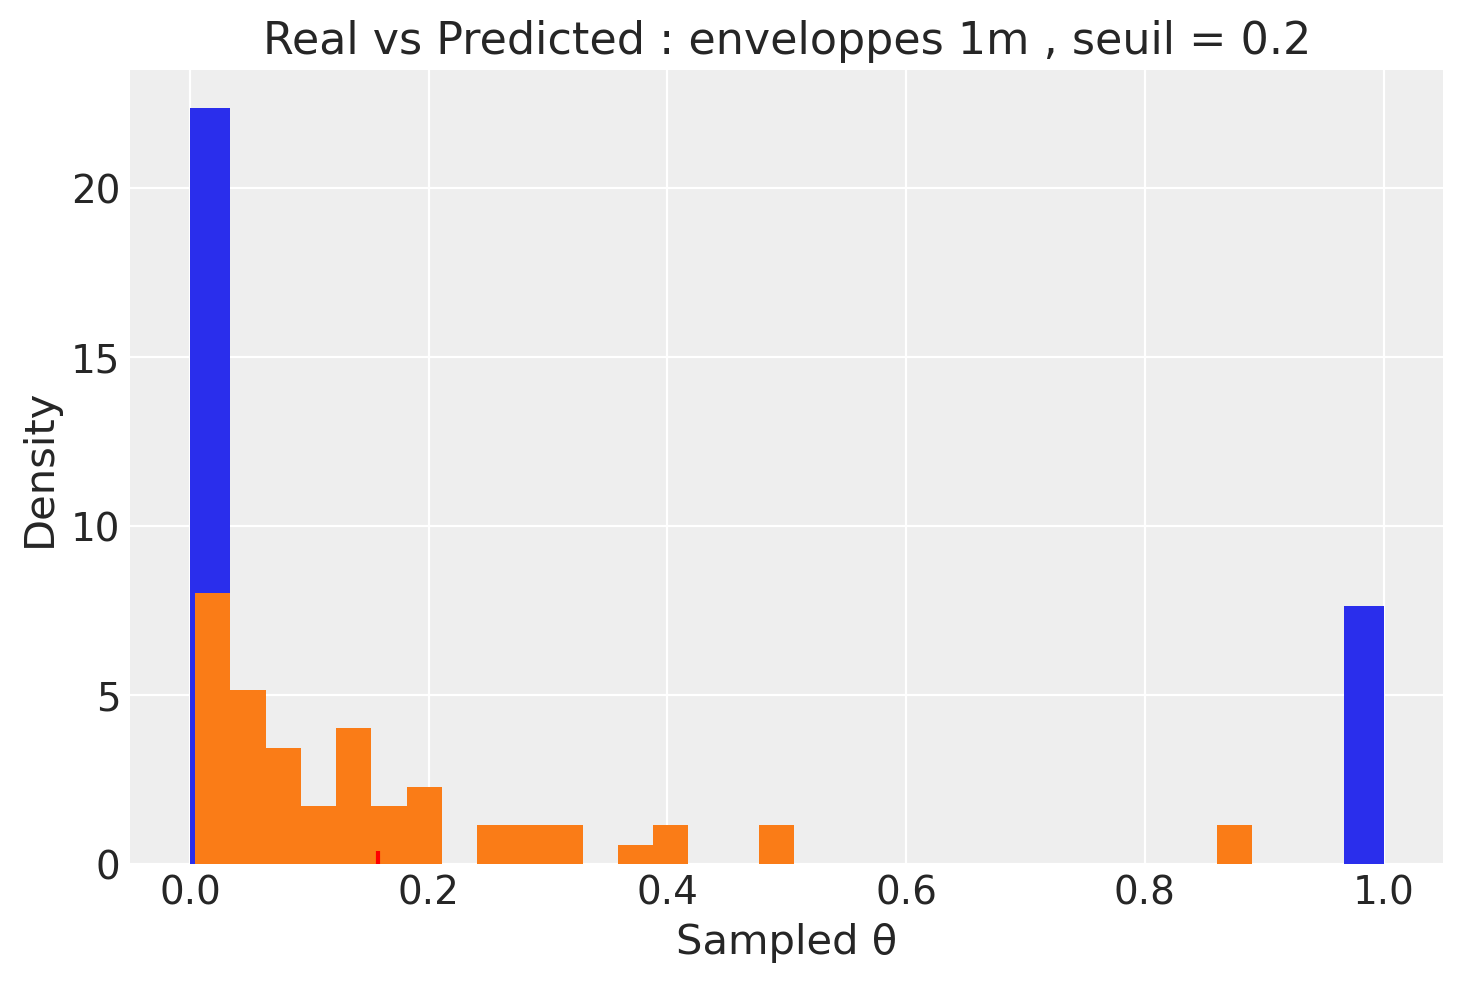

In [26]:
# Plot histogram  
plt.hist(y_true, bins=30, density=True)
plt.hist(y_pred, bins=30, density=True)
plt.vlines(y_pred.mean(), 0, 0.4, colors='r') 

plt.xlabel('Sampled θ')  
plt.ylabel('Density')
plt.title('Real vs Predicted : enveloppes 1m , seuil = 0.2')
   
plt.show()

In [27]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_pred > 0.5) 
print(accuracy)

0.7288135593220338


In [28]:
from sklearn.metrics import precision_score, recall_score  

precision = precision_score(y_true, y_pred > 0.5)  
recall = recall_score(y_true, y_pred > 0.5)

print(precision, recall)

0.3333333333333333 0.06666666666666667


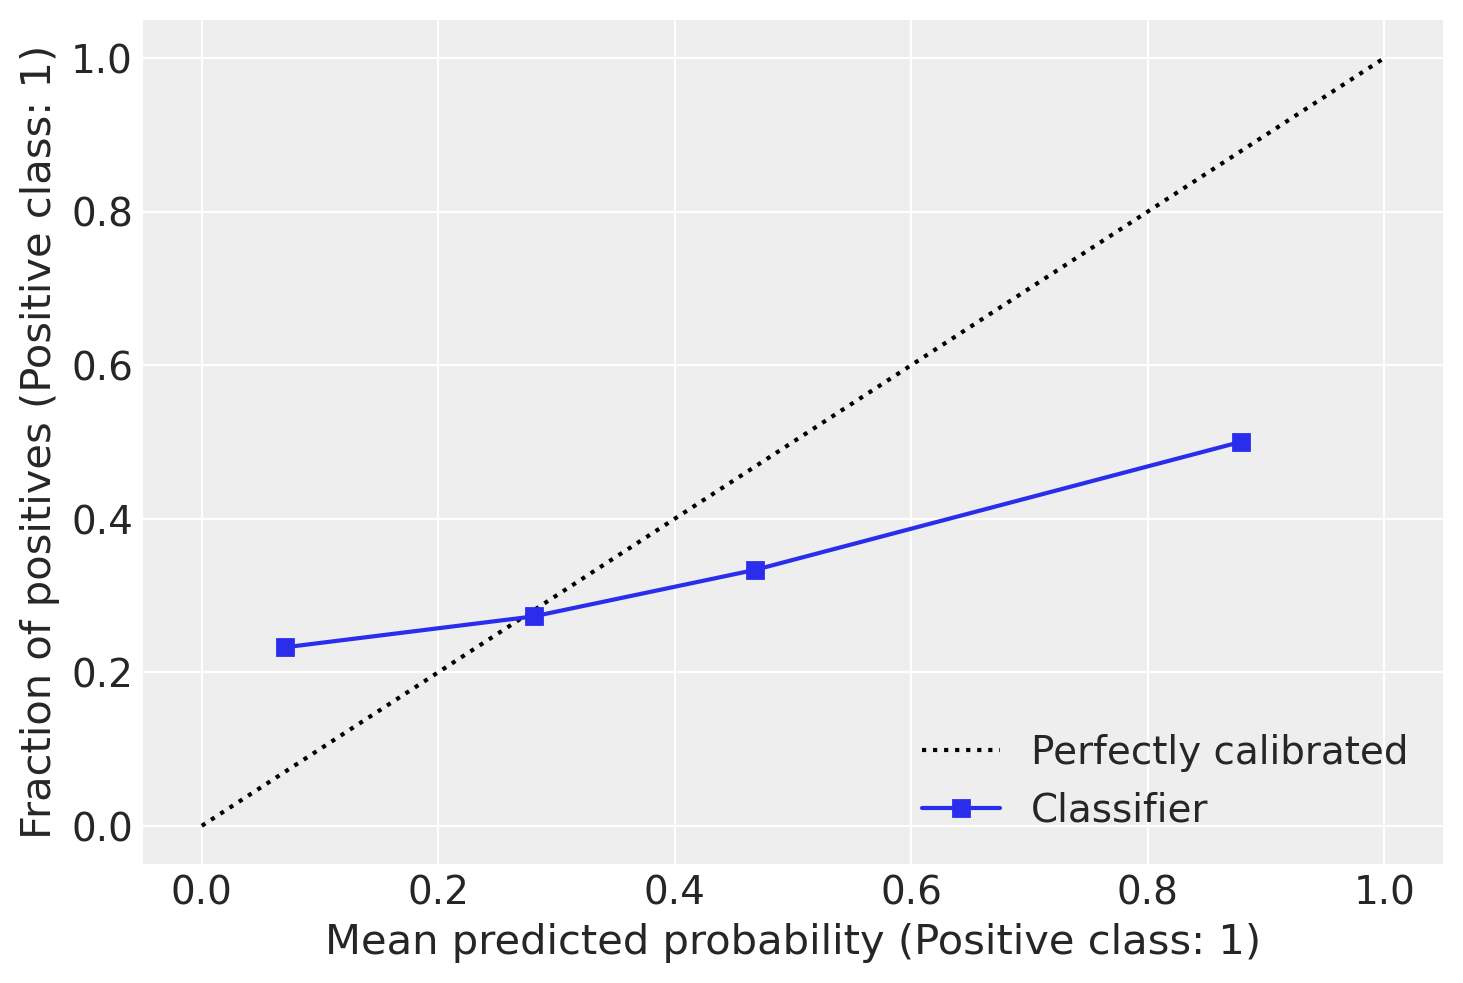

In [29]:
from sklearn.calibration import CalibrationDisplay

CalibrationDisplay.from_predictions(y_true, y_pred)

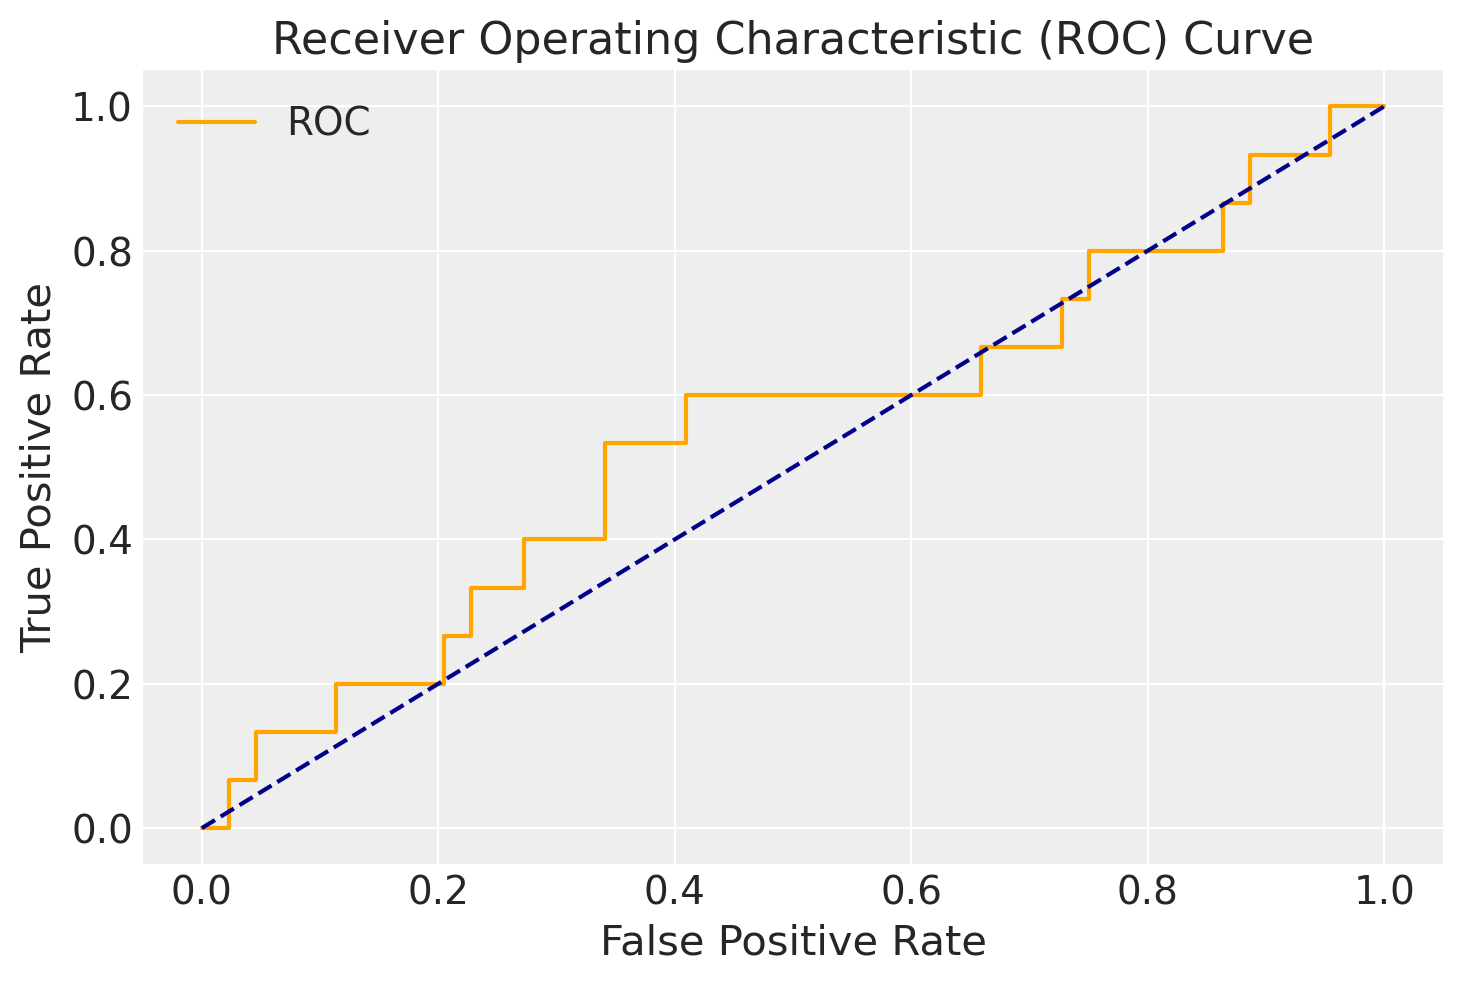

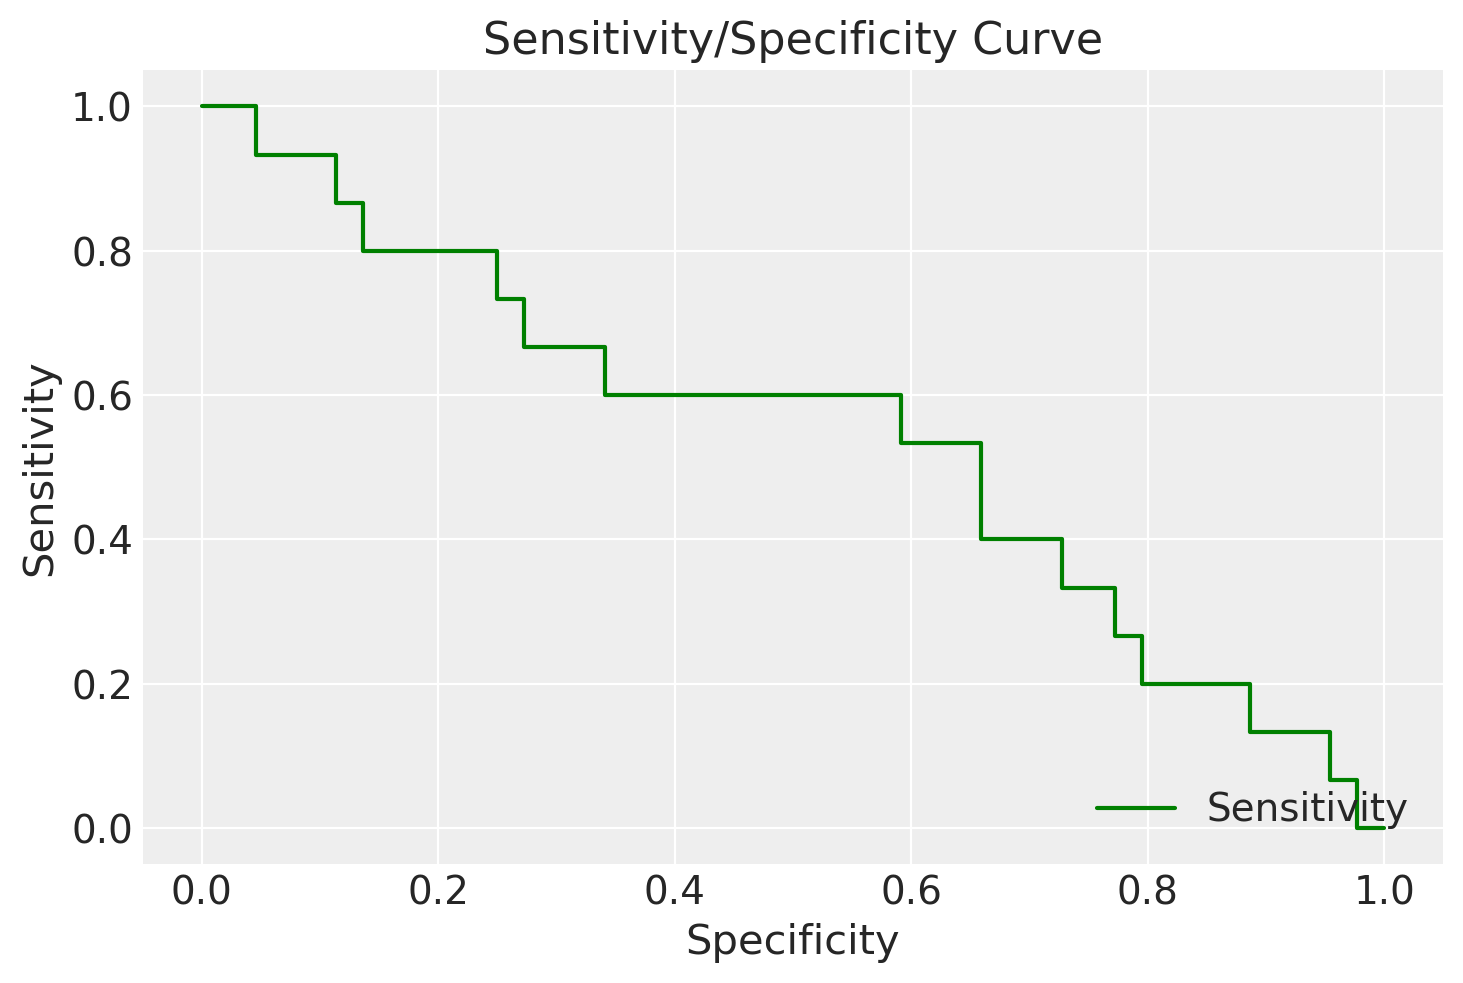

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_pred)

plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

specificity = 1 - fpr
plt.plot(specificity, tpr, color='green', label='Sensitivity')
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('Sensitivity/Specificity Curve')
plt.legend(loc="lower right")
plt.show()

# Posterior analysis

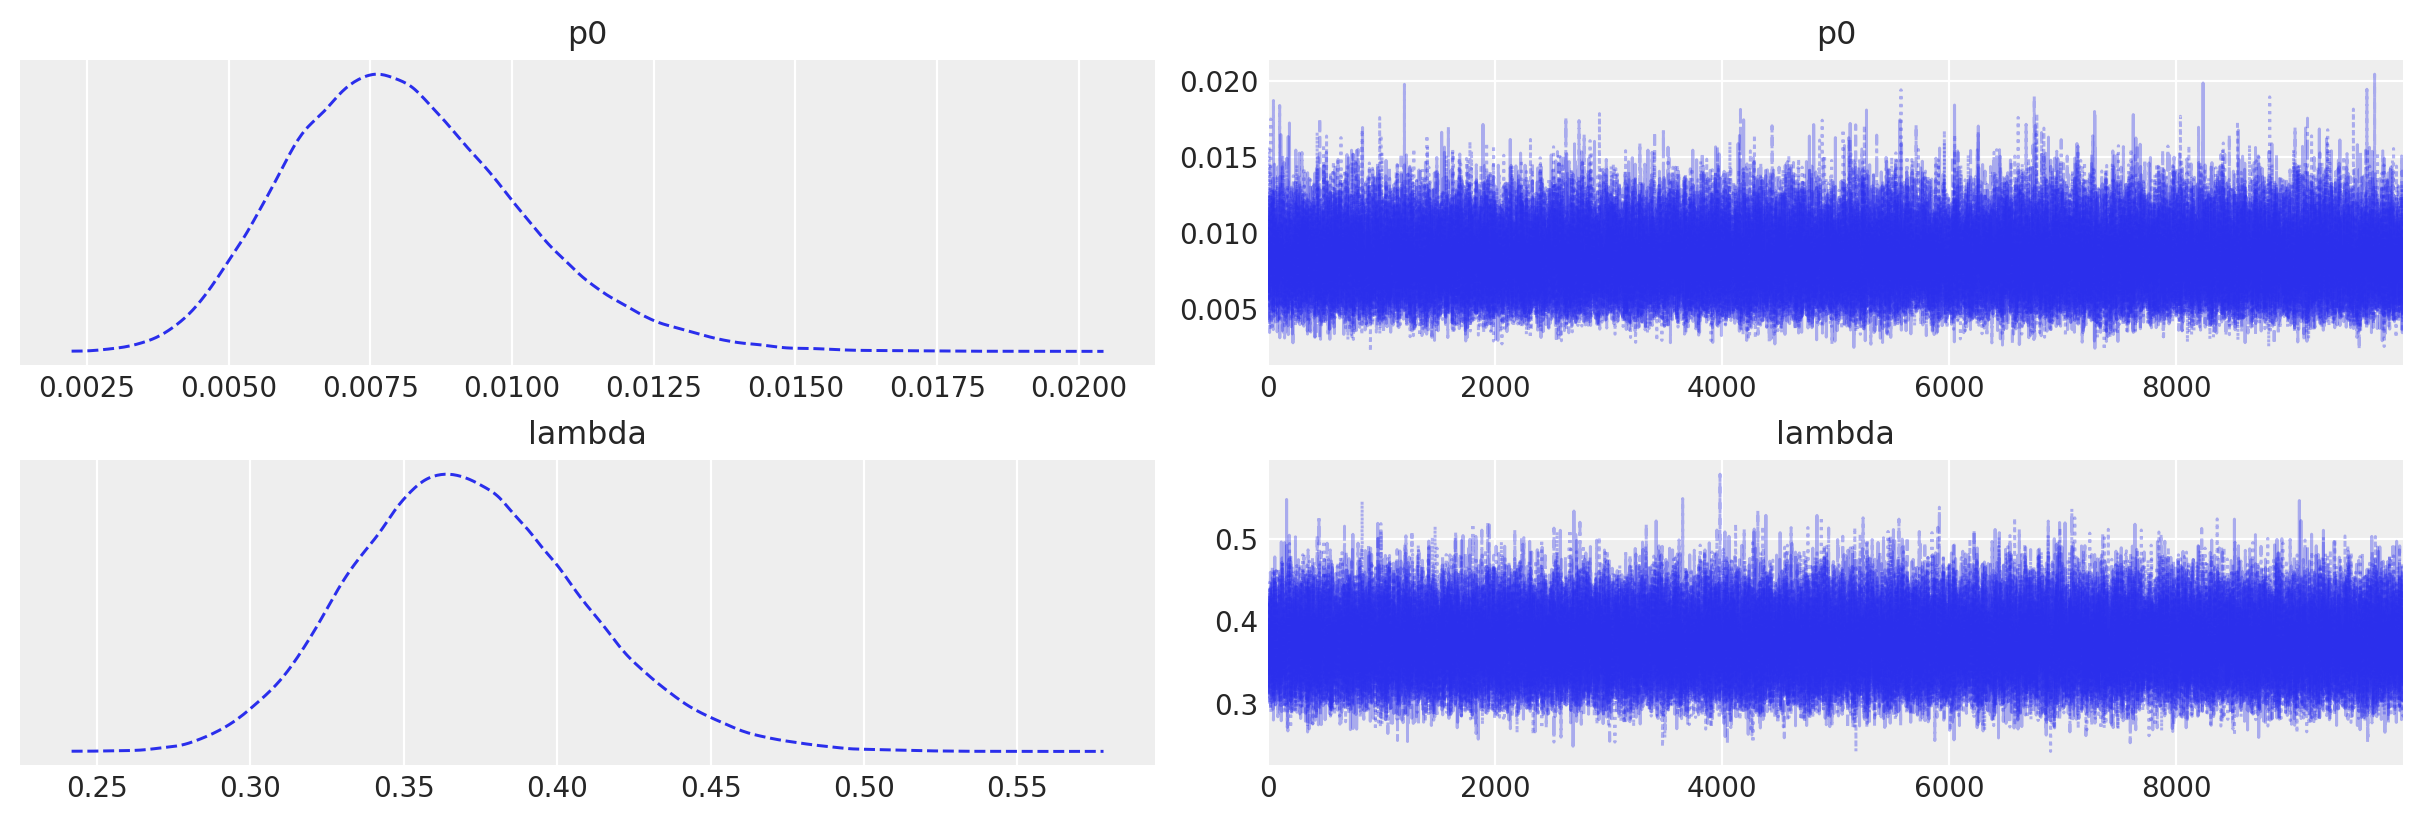

In [31]:
az.plot_trace(trace, combined=True);

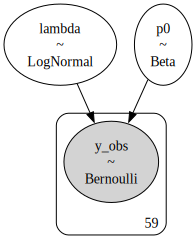

In [33]:
pm.model_to_graphviz(model)

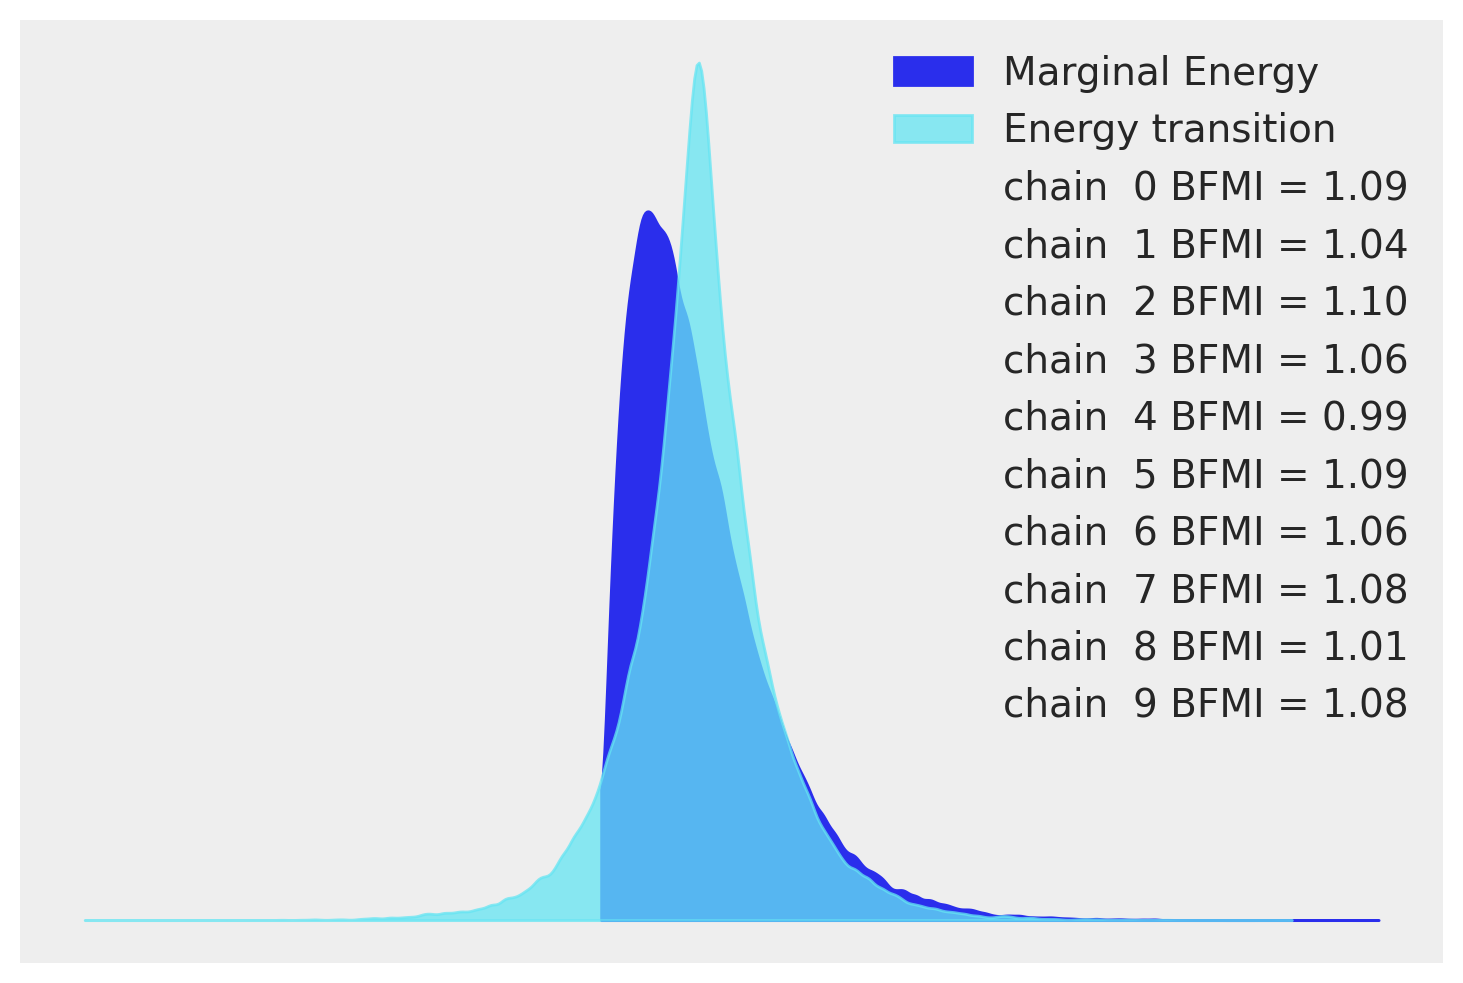

In [34]:
az.plot_energy(trace);

# Model log-likelihood

In [35]:
with model:
    pm.compute_log_likelihood(trace)

In [36]:
model_loo = az.loo(trace)

model_loo

Computed from 100000 posterior samples and 59 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -34.46     3.53
p_loo        0.99        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       59  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [37]:
model_waic = az.waic(trace)

model_waic

Computed from 100000 posterior samples and 59 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -34.46     3.53
p_waic        0.99        -

In [38]:
# Generate posterior predictive samples
with model:
    pm.sample_posterior_predictive(trace, random_seed=42, extend_inferencedata=True)

Sampling: [y_obs]


In [39]:
trace.posterior_predictive

<xarray.Dataset>
Dimensions:      (chain: 10, draw: 10000, y_obs_dim_2: 59)
Coordinates:
  * chain        (chain) int32 0 1 2 3 4 5 6 7 8 9
  * draw         (draw) int32 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
  * y_obs_dim_2  (y_obs_dim_2) int32 0 1 2 3 4 5 6 7 ... 51 52 53 54 55 56 57 58
Data variables:
    y_obs        (chain, draw, y_obs_dim_2) int64 1 1 1 0 1 0 1 ... 0 0 0 0 0 0
Attributes:
    created_at:                 2024-02-02T13:40:02.761690
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.10.3

c:\Users\manhi\anaconda3\envs\tf\lib\site-packages\arviz\plots\ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
c:\Users\manhi\anaconda3\envs\tf\lib\site-packages\arviz\plots\ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


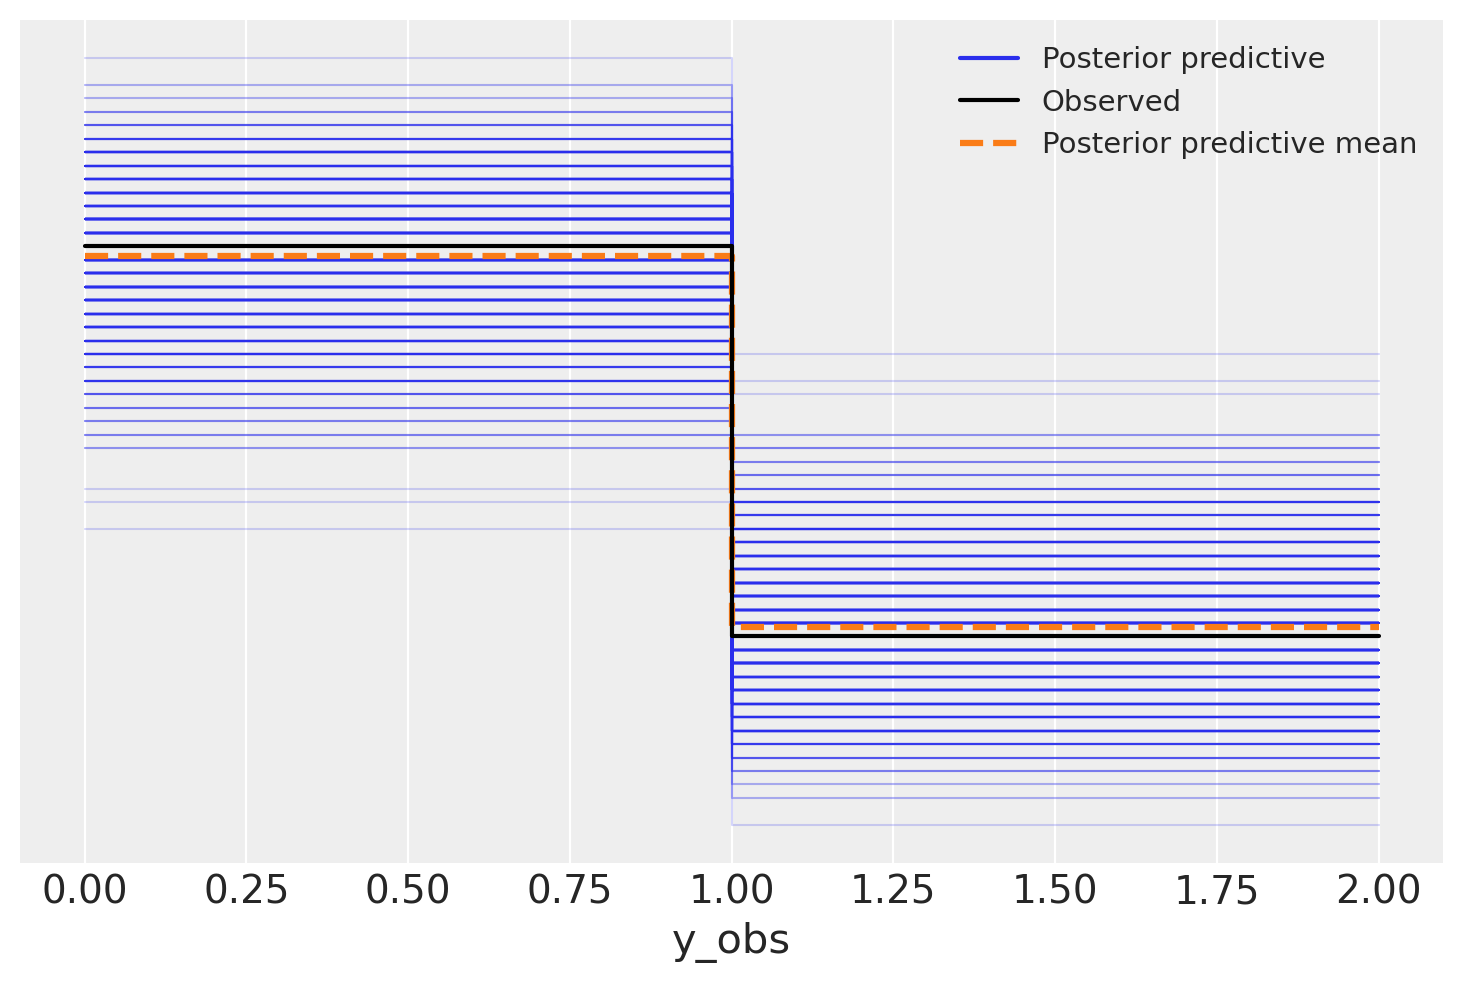

In [40]:
az.plot_ppc(trace, num_pp_samples=1000, kind = 'kde', group="posterior");

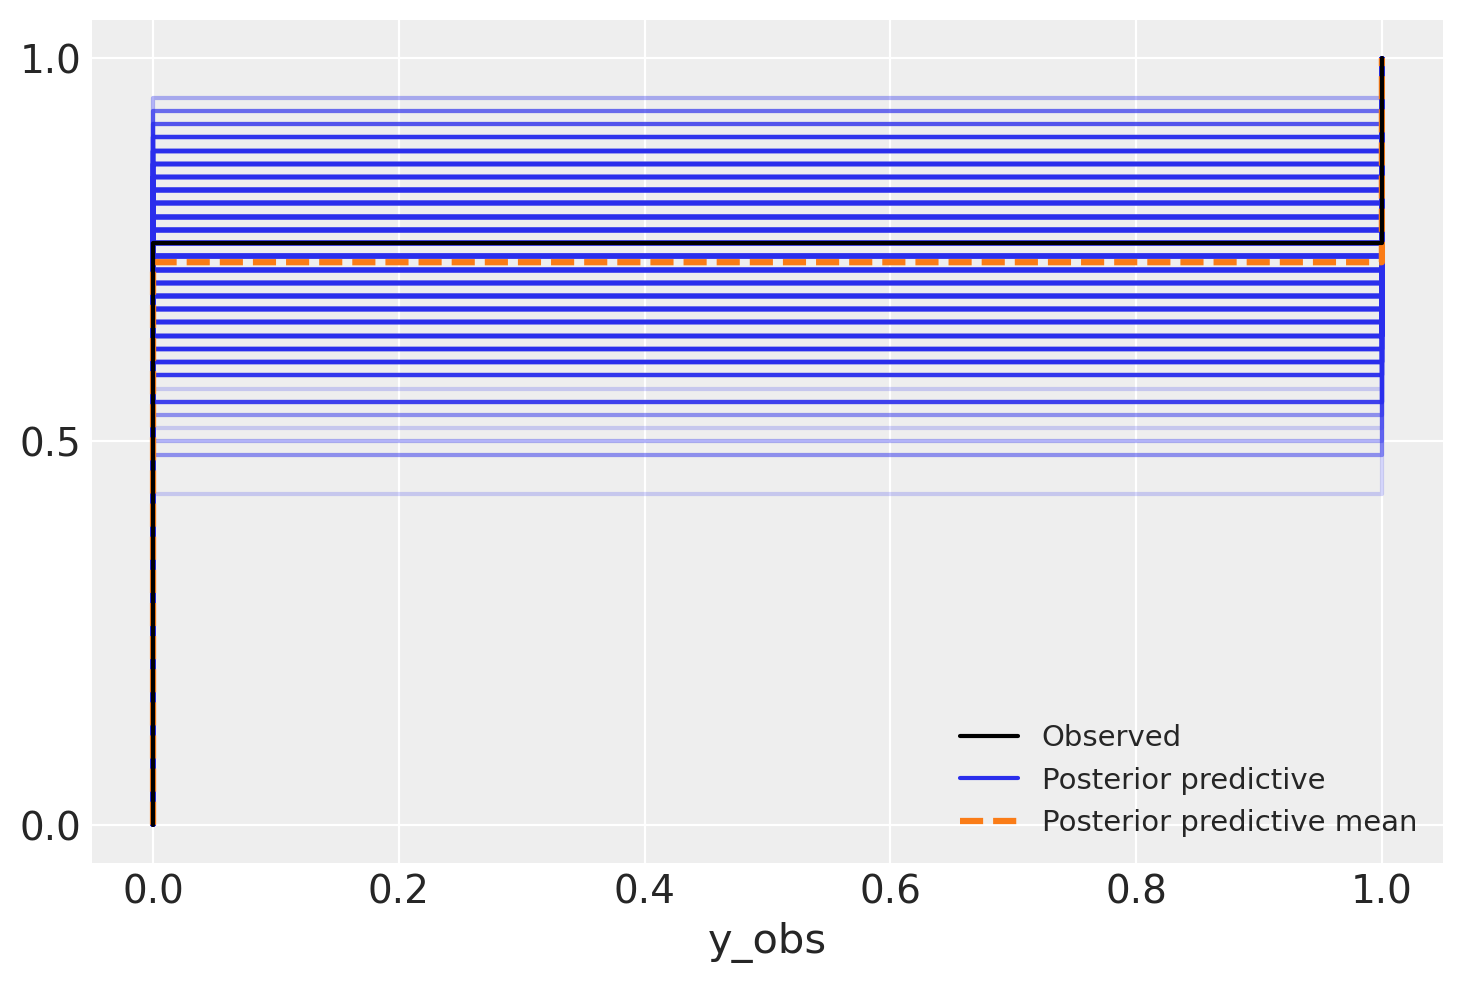

In [41]:
az.plot_ppc(trace, num_pp_samples=1000, kind = 'cumulative');

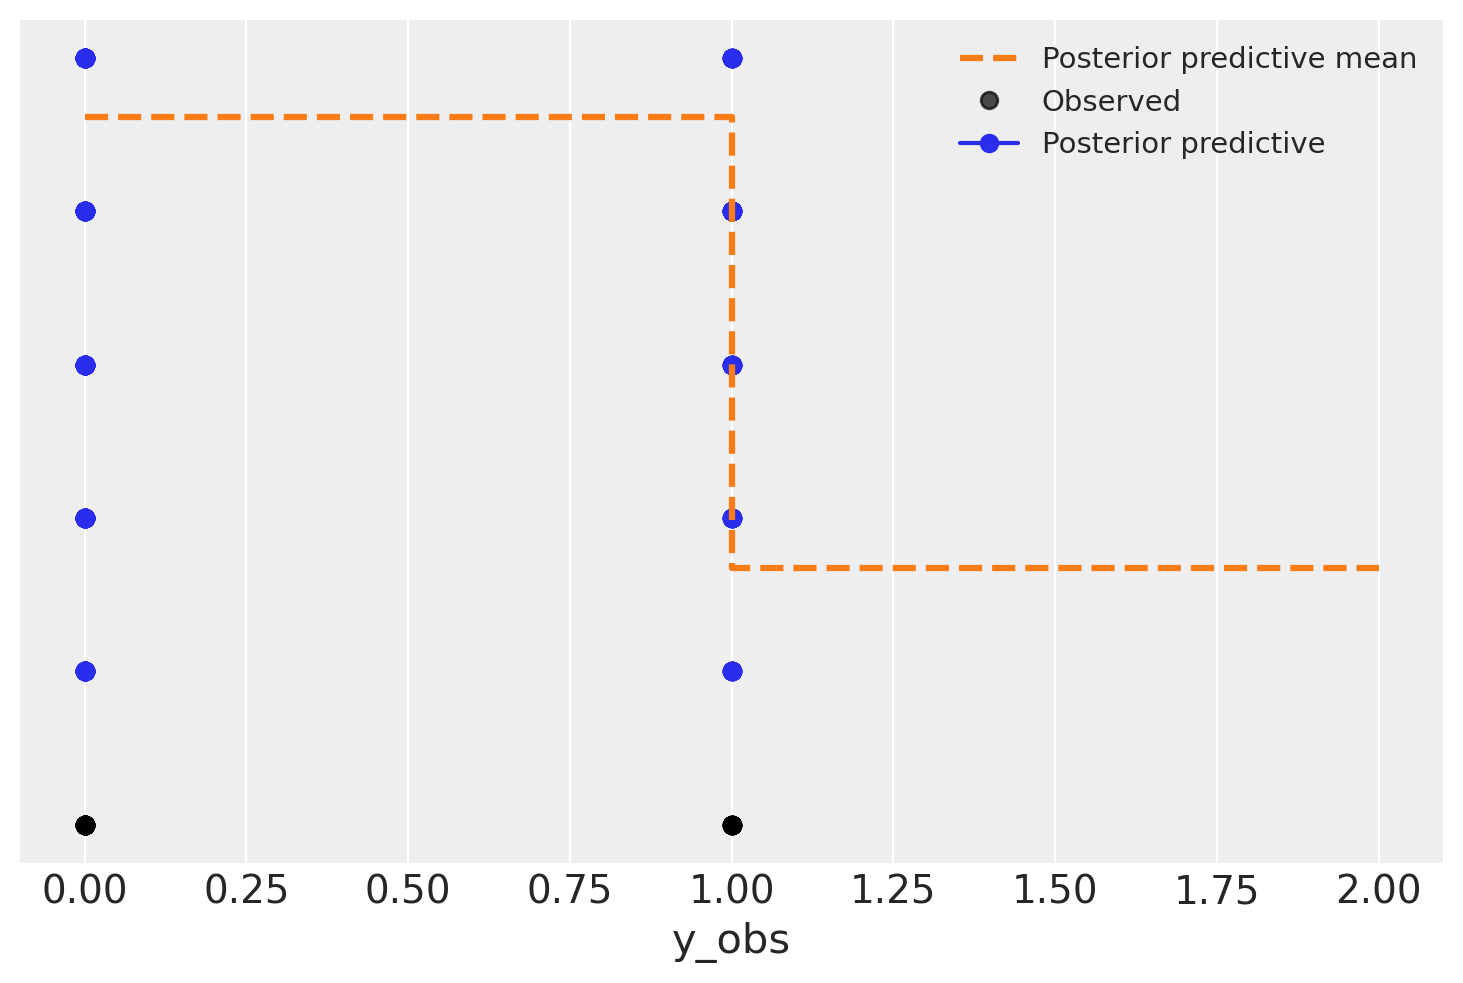

In [42]:
az.plot_ppc(trace, num_pp_samples=5, kind = 'scatter');

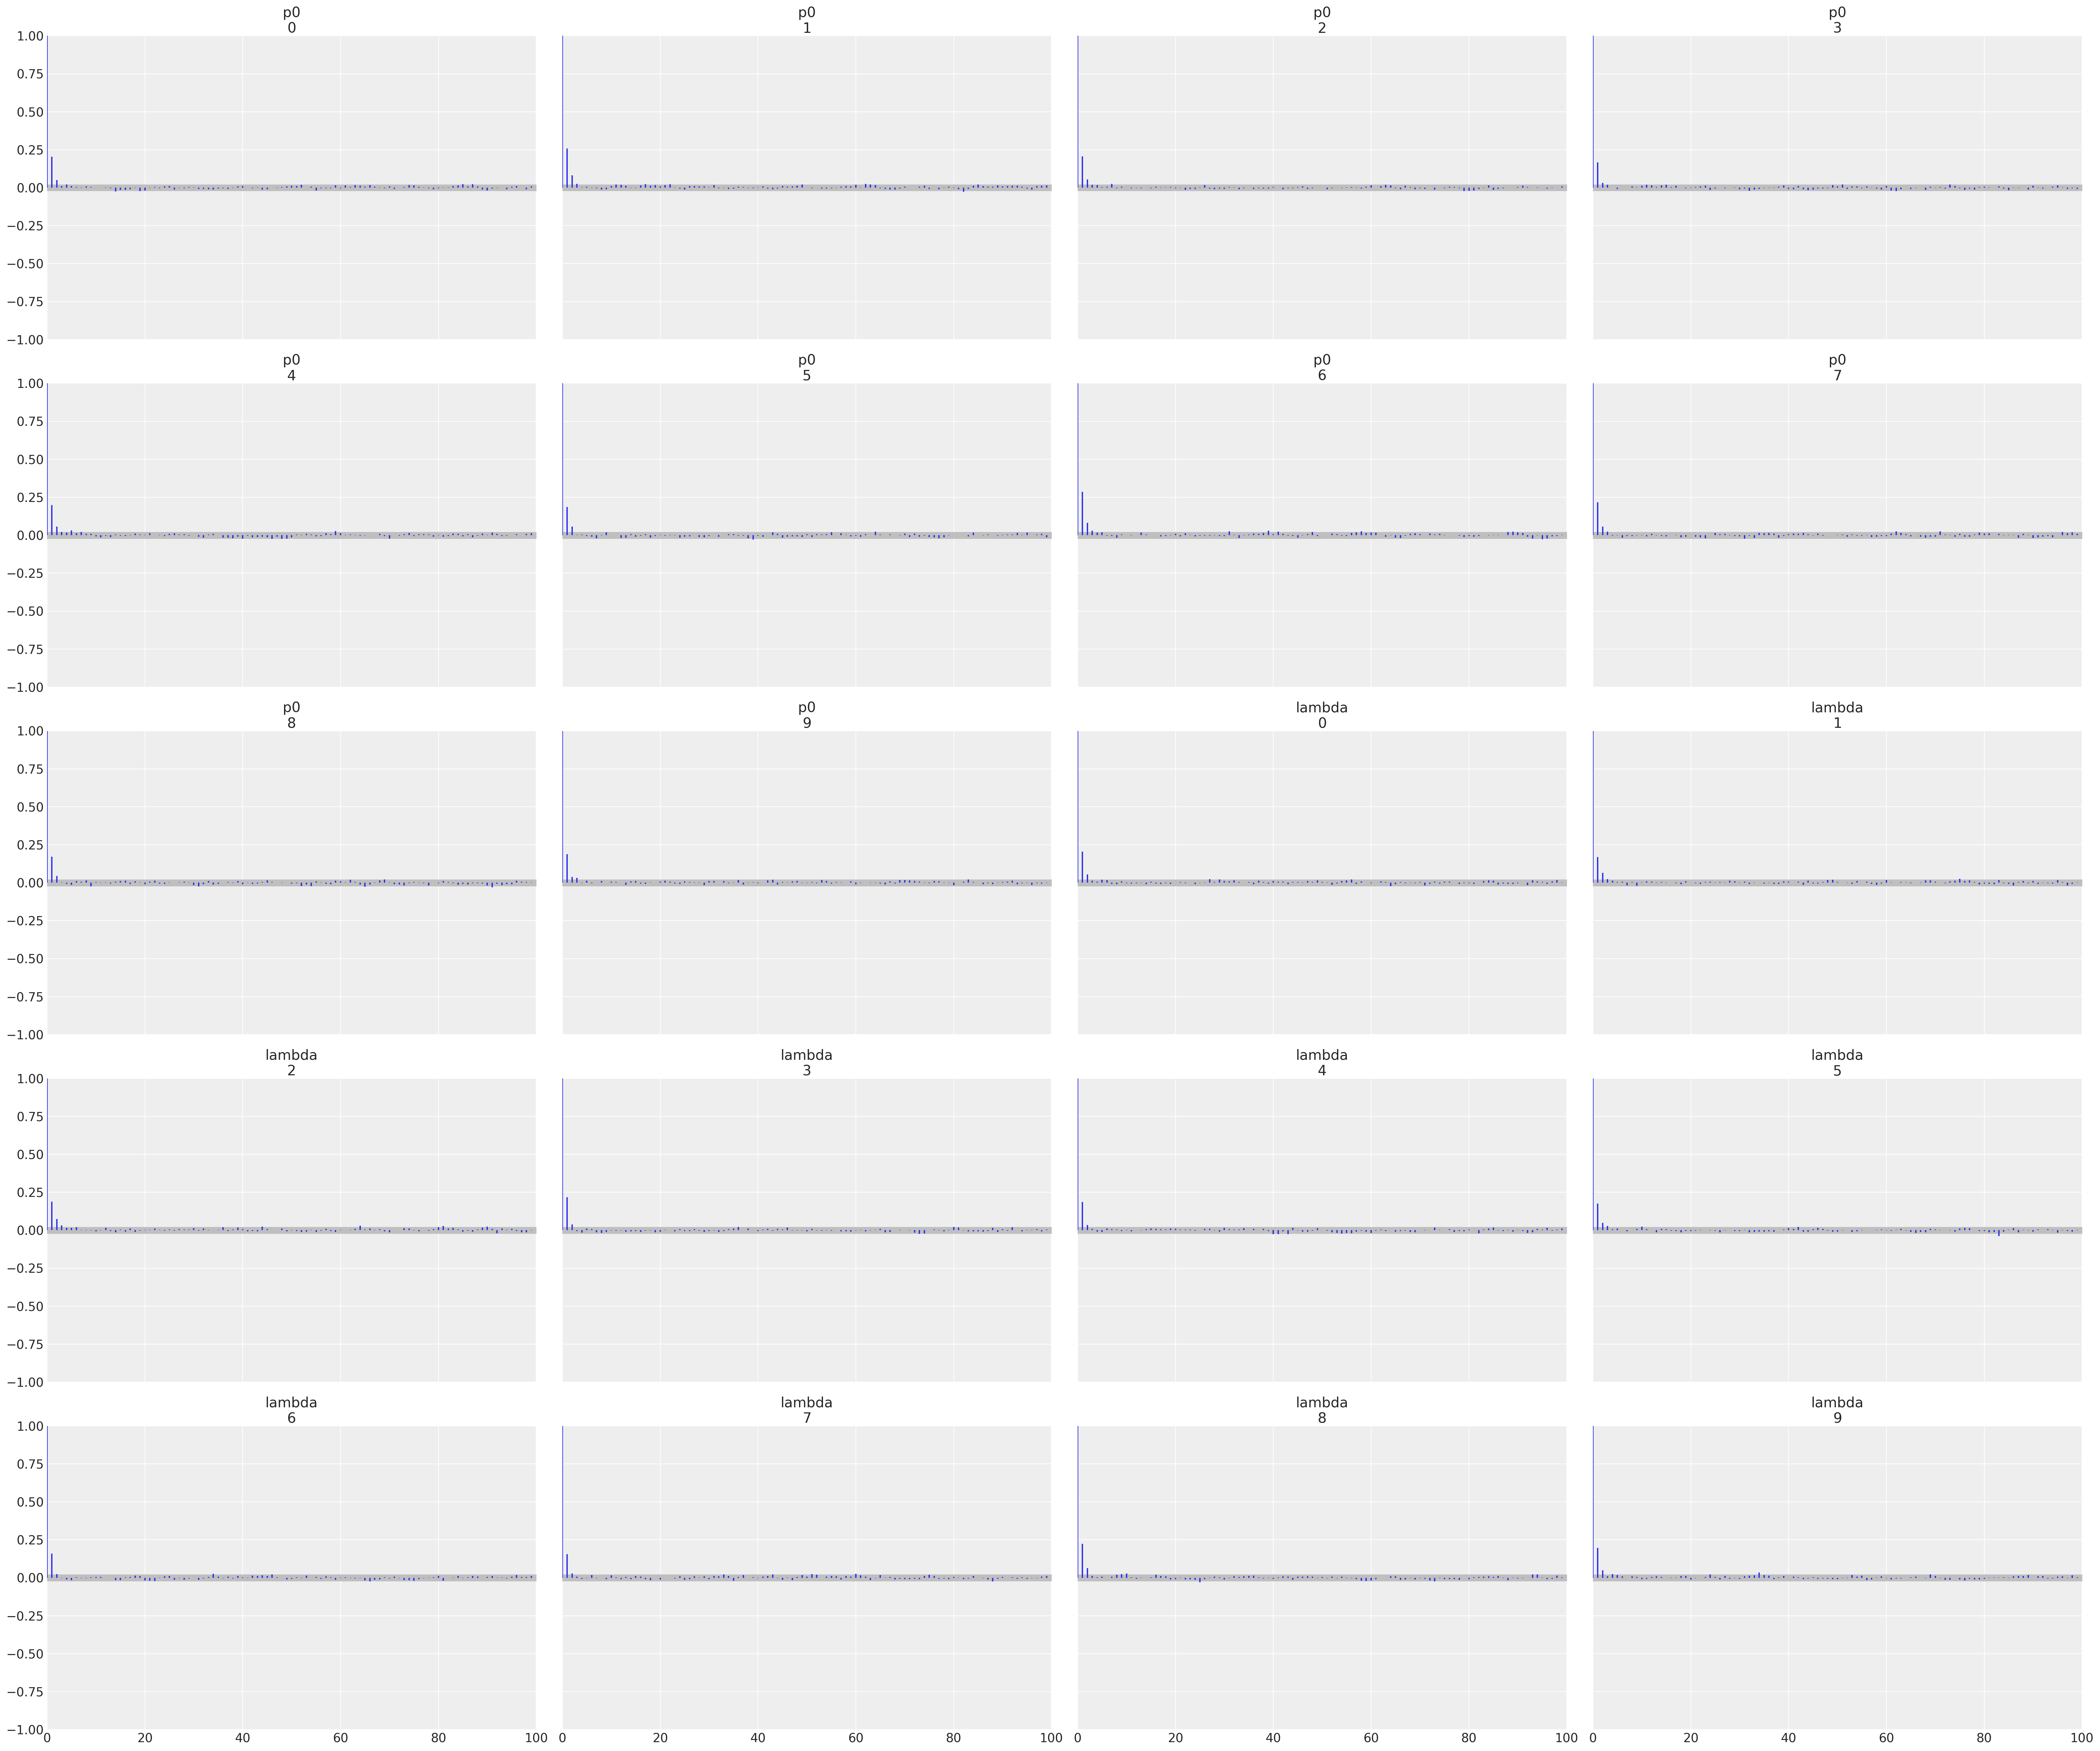

In [43]:
az.plot_autocorr(trace, var_names=["p0", "lambda"]);

In [44]:
# Gelman-Rubin convergence diagnostic
r_hat = az.rhat(trace, var_names=["p0", "lambda"])
print(r_hat)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    p0       float64 1.0
    lambda   float64 1.0


In [45]:
ess = az.ess(trace, var_names=["p0", "lambda"])

c:\Users\manhi\anaconda3\envs\tf\lib\site-packages\arviz\plots\essplot.py:205: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_draws = data.dims["draw"]
c:\Users\manhi\anaconda3\envs\tf\lib\site-packages\arviz\plots\essplot.py:206: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_samples = n_draws * data.dims["chain"]


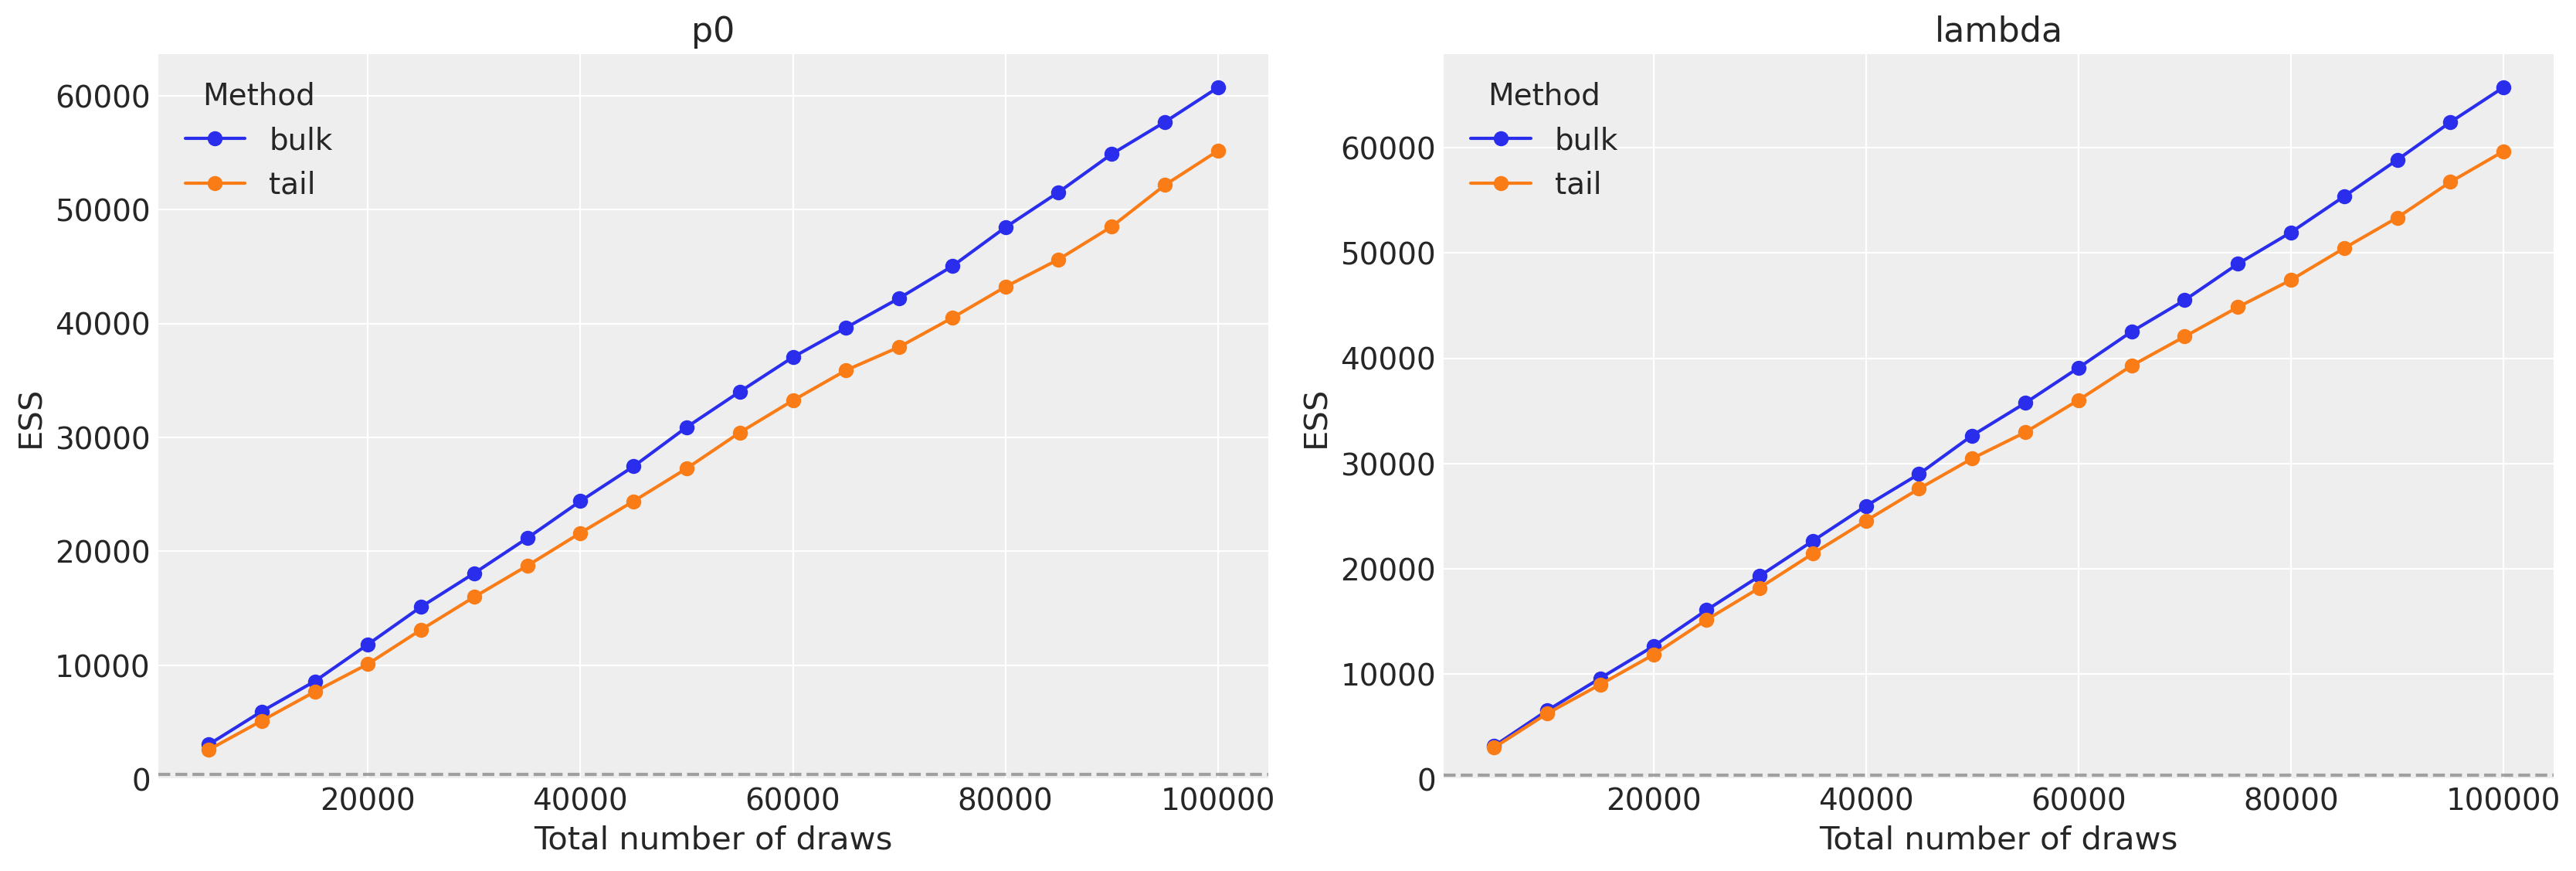

In [46]:
az.plot_ess(trace, var_names=["p0", "lambda"], kind="evolution");

In [47]:
total_ess = ess["p0"].sum().values
print(f"Total effective sample size for p0: {float(total_ess):.2f}")

Total effective sample size for p0: 60723.13


In [48]:
total_ess = ess["lambda"].sum().values
print(f"Total effective sample size for lambda: {float(total_ess):.2f}")

Total effective sample size for lambda: 65749.41
